<a href="https://colab.research.google.com/github/Moya505/Adaptive-Behavioral-Anomaly-Detection-for-Fraudulent-Transactions/blob/main/Adaptive_Behavioral_Anomaly_Detection_for_Fraudulent_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the PaySim dataset
# df = pd.read_csv('/content/drive/MyDrive/PS_20174392719_1491204439457_log.csv')  # Adjust filename as needed
from google.colab import drive
drive.mount('/content/drive')

# After mounting, you can access files in your Drive
# For example, if 'my_data.csv' is in a folder named 'Colab Notebooks'
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/PS_20174392719_1491204439457_log.csv')

# Display basic info
print("="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Total transactions: {len(df):,}")
print(f"Number of columns: {df.shape[1]}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATASET OVERVIEW
Total transactions: 4,245,000
Number of columns: 20

Column names: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'orig_txn_count', 'orig_total_amount', 'orig_avg_amount', 'origin_balance_delta', 'dest_balance_delta', 'is_high_risk_type', 'log_amount', 'amount_vs_avg', 'orig_transaction_count']

Memory usage: 1260.61 MB


In [3]:
print("\n" + "="*50)
print("FIRST 10 TRANSACTIONS")
print("="*50)
print(df.head(10))

# Show data types
print("\n" + "="*50)
print("DATA TYPES & MISSING VALUES")
print("="*50)
print(df.info())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


FIRST 10 TRANSACTIONS
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815      170136.00       160296.36   
1     1   PAYMENT   1864.28  C1666544295       21249.00        19384.72   
2     1  TRANSFER    181.00  C1305486145         181.00            0.00   
3     1  CASH_OUT    181.00   C840083671         181.00            0.00   
4     1   PAYMENT  11668.14  C2048537720       41554.00        29885.86   
5     1   PAYMENT   7817.71    C90045638       53860.00        46042.29   
6     1   PAYMENT   7107.77   C154988899      183195.00       176087.23   
7     1   PAYMENT   7861.64  C1912850431      176087.23       168225.59   
8     1   PAYMENT   4024.36  C1265012928        2671.00            0.00   
9     1     DEBIT   5337.77   C712410124       41720.00        36382.23   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0            0.00        0               0  
1  

In [3]:
print("\n" + "="*50)
print("FRAUD vs NORMAL TRANSACTIONS")
print("="*50)

# Count fraud cases
fraud_counts = df['isFraud'].value_counts()
print("\nAbsolute Counts:")
print(f"Normal (0): {fraud_counts[0]:,}")
print(f"Fraud (1):  {fraud_counts[1]:,}")

# Calculate percentages
fraud_rate = df['isFraud'].mean() * 100
normal_rate = 100 - fraud_rate
print(f"\nPercentages:")
print(f"Normal: {normal_rate:.2f}%")
print(f"Fraud:  {fraud_rate:.2f}%")

print(f"\n Class Imbalance Ratio: 1:{fraud_counts[0]//fraud_counts[1]}")
print(f"   (For every 1 fraud, there are ~{fraud_counts[0]//fraud_counts[1]} normal transactions)")


FRAUD vs NORMAL TRANSACTIONS

Absolute Counts:
Normal (0): 4,241,545
Fraud (1):  3,455

Percentages:
Normal: 99.92%
Fraud:  0.08%

 Class Imbalance Ratio: 1:1227
   (For every 1 fraud, there are ~1227 normal transactions)


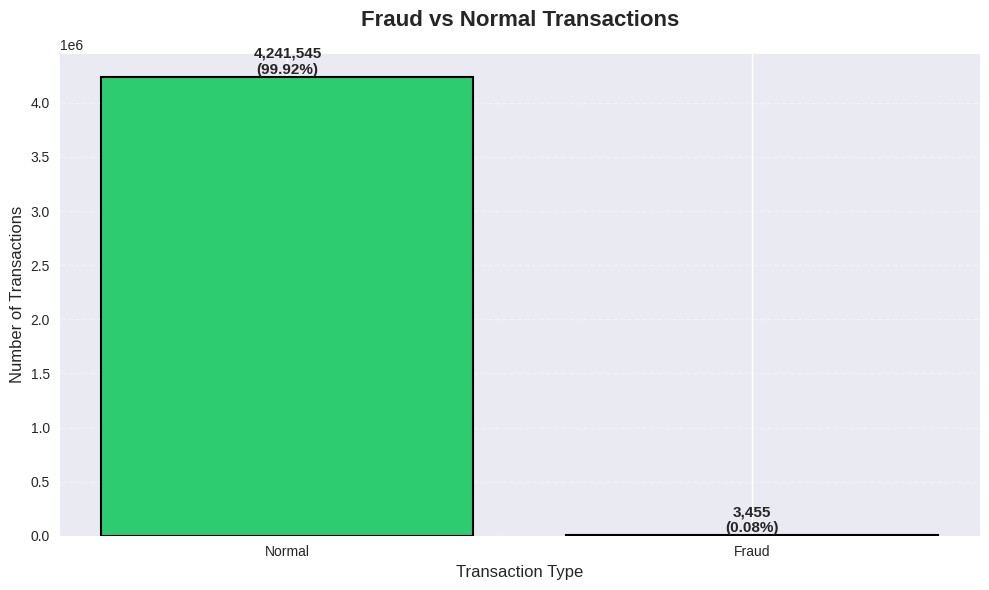


TRANSACTION TYPES BREAKDOWN
type
CASH_OUT    1508348
PAYMENT     1429264
CASH_IN      929830
TRANSFER     351445
DEBIT         26113
Name: count, dtype: int64


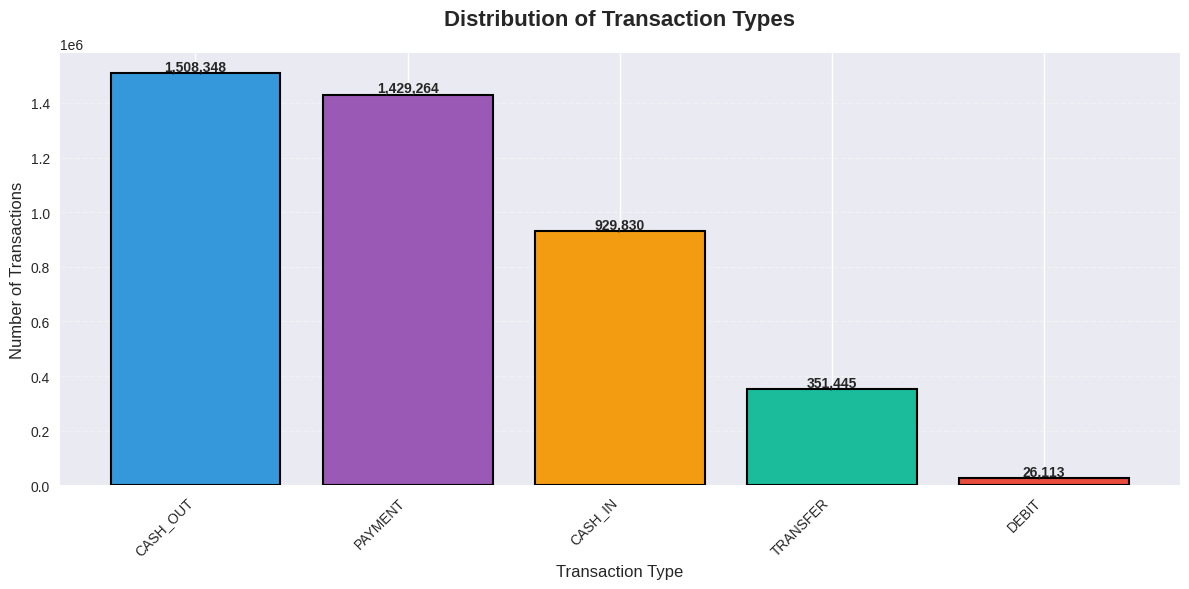


FRAUD RATES BY TRANSACTION TYPE
          Fraud_Count  Total_Count  Fraud_Rate
type                                          
TRANSFER         1718       351445    0.488839
CASH_OUT         1737      1508348    0.115159
CASH_IN             0       929830    0.000000
DEBIT               0        26113    0.000000
PAYMENT             0      1429264    0.000000


In [4]:
# 4a. Fraud vs Normal Bar Chart
plt.figure(figsize=(10, 6))
colors = ['#2ecc71', '#e74c3c']  # Green for normal, red for fraud
bars = plt.bar(['Normal', 'Fraud'], fraud_counts.values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}\n({height/len(df)*100:.2f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Fraud vs Normal Transactions', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xlabel('Transaction Type', fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('fraud_vs_normal.png', dpi=300, bbox_inches='tight')
plt.show()

# 4b. Transaction Types Chart (PAYMENT, TRANSFER, CASH_OUT, etc.)
print("\n" + "="*50)
print("TRANSACTION TYPES BREAKDOWN")
print("="*50)

type_counts = df['type'].value_counts()
print(type_counts)

plt.figure(figsize=(12, 6))
colors_types = ['#3498db', '#9b59b6', '#f39c12', '#1abc9c', '#e74c3c']
bars = plt.bar(type_counts.index, type_counts.values, color=colors_types, edgecolor='black', linewidth=1.5)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Distribution of Transaction Types', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xlabel('Transaction Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('transaction_types.png', dpi=300, bbox_inches='tight')
plt.show()

# 4c. Fraud by Transaction Type
print("\n" + "="*50)
print("FRAUD RATES BY TRANSACTION TYPE")
print("="*50)

fraud_by_type = df.groupby('type')['isFraud'].agg(['sum', 'count', 'mean'])
fraud_by_type.columns = ['Fraud_Count', 'Total_Count', 'Fraud_Rate']
fraud_by_type['Fraud_Rate'] = fraud_by_type['Fraud_Rate'] * 100
print(fraud_by_type.sort_values('Fraud_Rate', ascending=False))

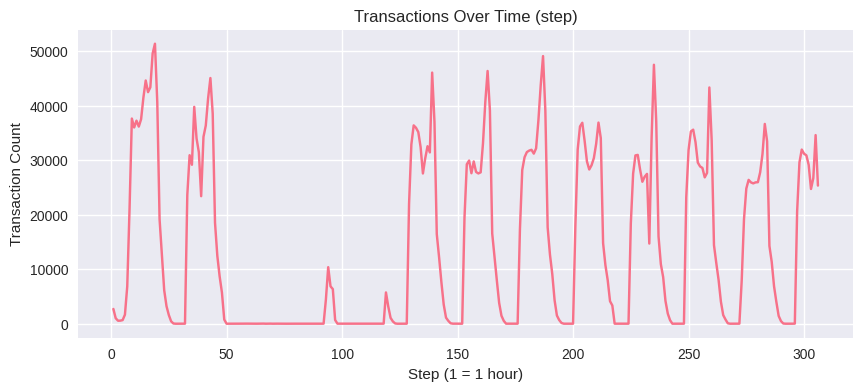

In [5]:
plt.figure(figsize=(10,4))
df.groupby('step').size().plot()
plt.title("Transactions Over Time (step)")
plt.xlabel("Step (1 = 1 hour)")
plt.ylabel("Transaction Count")
plt.show()

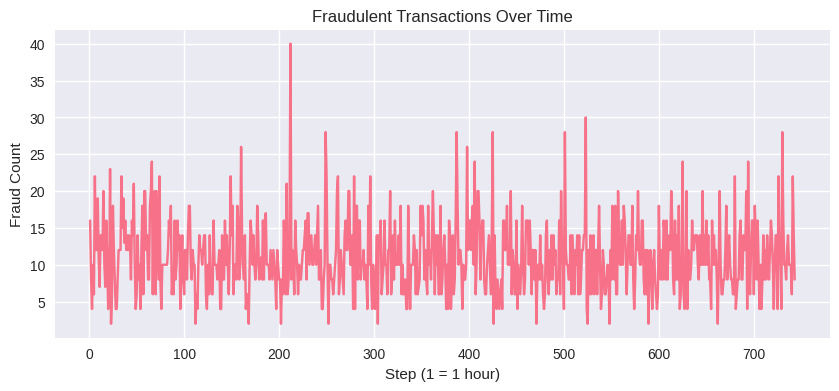

In [12]:
plt.figure(figsize=(10,4))
df[df['isFraud']==1].groupby('step').size().plot()
plt.title("Fraudulent Transactions Over Time")
plt.xlabel("Step (1 = 1 hour)")
plt.ylabel("Fraud Count")
plt.show()

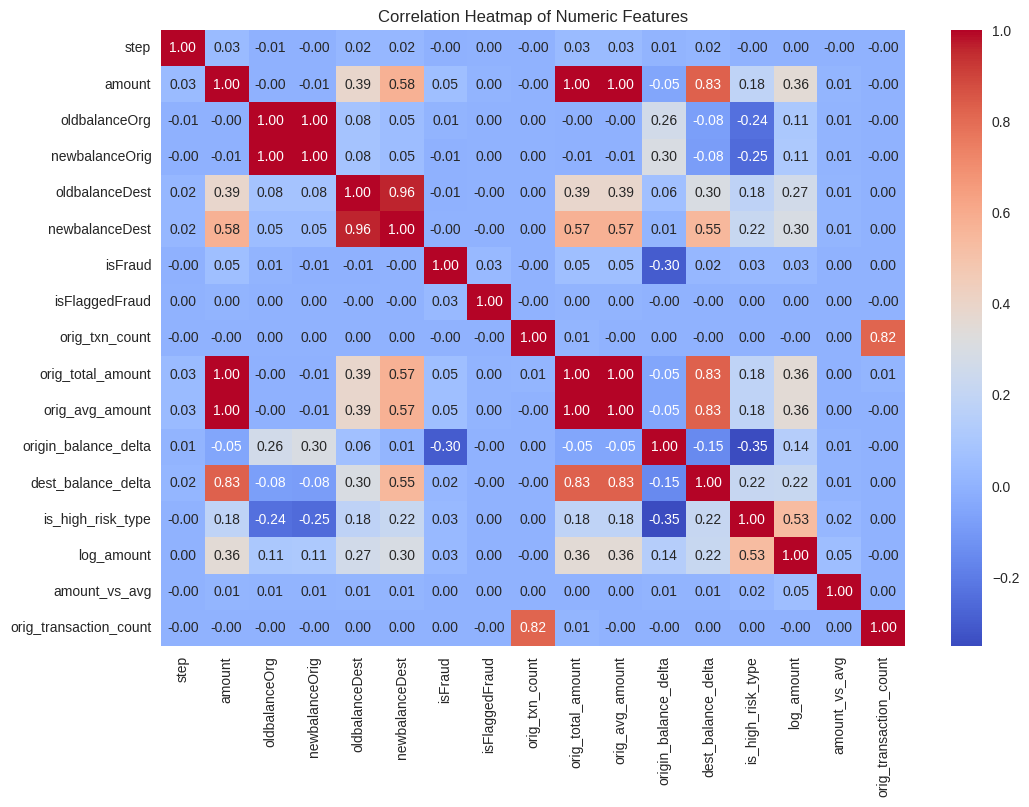

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

In [8]:
import numpy as np
import pandas as pd

# 1. Origin account features
df['orig_txn_count'] = df.groupby('nameOrig')['amount'].transform('count')
df['orig_total_amount'] = df.groupby('nameOrig')['amount'].transform('sum')
df['orig_avg_amount'] = df.groupby('nameOrig')['amount'].transform('mean')

# 2. Balance features
df['origin_balance_delta'] = df['newbalanceOrig'] - df['oldbalanceOrg']

# Destination is normal
df['dest_balance_delta'] = df['newbalanceDest'] - df['oldbalanceDest']

# 3. High-risk transaction flag
df['is_high_risk_type'] = df['type'].isin(['TRANSFER', 'CASH_OUT']).astype(int)

# 4. Amount Transformations
df['log_amount'] = np.log1p(df['amount'])
df['amount_vs_avg'] = df['amount'] / (df['orig_avg_amount'] + 1)

# 5. Clean
df = df.fillna(0)

# 6. Save
output_path = "/content/drive/MyDrive/PS_20174392719_1491204439457_log.csv"
df.to_csv(output_path, index=False)

print(f"Saved to: {output_path}")
print("\nNew columns added:")
print([col for col in df.columns if col not in
       ['step','type','amount','nameOrig','nameDest',
        'oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
        'isFraud','isFlaggedFraud']])


KeyboardInterrupt: 